# Cluster Analysis

This experimental notebook explores an inventory of landscapes accross Switzerland, with the aim of classifying them by means of landscape metrics. The approach is based on the work of Nowosad and Stepinski (2019) [1]. 

In the cell below, the notebook introduces a preliminary implementation of a `ClusterAnalysis` class, which will eventually be integrated to the pylandstats library. Then, the cells of the Data processing section serve to generate a landscape inventory by randomly sampling small regions accross Switzerland. If you are mainly interested in the landscape ecology part, feel free to skip to section [Cluster analysis with ten metrics and principal component analysis (PCA)](#cluster-analysis-ten-metrics-pca).

In [ ]:
import tempfile
from os import path

import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
import rasterio as rio
import seaborn as sns
import swisslandstats as sls
import tqdm
from numpy import random
from rasterio import mask
from sklearn import cluster, decomposition, metrics

import pylandstats as pls


class ClusterAnalysis(object):
    """Cluster analysis of landscapes based on landscape metrics."""

    def __init__(
        self,
        landscapes,
        metrics,
        kmeans_kws=None,
        pca_kws=None,
        pca=False,
        silhouette_score_kws=None,
    ):
        """
        Initialize the cluster analysis.

        Parameters
        ----------
        landscapes : list-like
            The list-like of `pylandstats.Landscape` instances.
        metrics : list-like
            A list-like of strings with the names of the metrics that should be
            computed. Note that they will be computed at the landscape level.
        kmeans_kws : dict, optional
            Keyword arguments to be passed to the initialization of
            `sklearn.cluster.KMeans`.
        pca_kws : dict, optional
            Keyword arguments to be passed to the initialization of
            `sklearn.decomposition.PCA`.
        pca : bool, default False
            Whether the principal component analysis of the metrics should be performed.
            Ignored if pca_kws is not None (default).
        silhouette_score_kws : dict, optional
            Keyword arguments to be passed to `sklearn.metrics.silhouette_score` when
            computing the `silhouette_score` property of this class.
        """
        self.landscapes = landscapes
        # self.metrics = metrics
        # TODO: how to handle NaN values in `self.metrics_df`?
        self.metrics_df = pd.concat(
            [
                ls.compute_landscape_metrics_df(metrics=metrics)
                for ls in tqdm.tqdm(landscapes)
            ],
            ignore_index=True,
        )
        self.kmeans = cluster.KMeans(**kmeans_kws).fit(self.metrics_df)
        if pca_kws or pca:
            self.pca = decomposition.PCA(**pca_kws).fit(self.metrics_df)
            self.pca_df = pd.DataFrame(self.pca.transform(self.metrics_df))

        if silhouette_score_kws is None:
            silhouette_score_kws = {}
        self._silhouette_score_kws = silhouette_score_kws

    @property
    def silhouette_score(self):
        """Silhouette score."""
        try:
            return self._silhouette_score
        except AttributeError:
            self._silhouette_score = metrics.silhouette_score(
                self.metrics_df, self.kmeans.labels_, **self._silhouette_score_kws
            )

            return self._silhouette_score

    def _scatterplot_clusters(
        self,
        x,
        y,
        data,
        cluster_centers,
        palette_name=None,
        scatterplot_kws=None,
        center_plot_kws=None,
    ):
        if scatterplot_kws is None:
            scatterplot_kws = {}
        if center_plot_kws is None:
            center_plot_kws = {}

        palette = scatterplot_kws.copy().pop(
            "palette", sns.color_palette(palette_name, n_colors=self.kmeans.n_clusters)
        )
        ax = sns.scatterplot(
            x=x,
            y=y,
            hue=pd.Series(self.kmeans.labels_, name="cluster"),
            data=data,
            palette=palette,
            **scatterplot_kws,
        )

        for color, cluster_center in zip(palette, cluster_centers):
            ax.plot(
                cluster_center[0], cluster_center[1], color=color, **center_plot_kws
            )

        return ax

    def scatterplot_cluster_metrics(
        self,
        metric_x,
        metric_y,
        palette_name=None,
        scatterplot_kws=None,
        center_plot_kws=None,
    ):
        """
        Scatterplot the landscape samples colored by their cluster.

        Parameters
        ----------
        metric_x, metric_y : str
            Strings with the names of the metrics to be plotted on the x and y axes
            respectively.
        palette_name : str, optional
            Name of palette or None to return current palette
        scatterplot_kws : dict, optional
            Keyword arguments to be passed to `seaborn.scatterplot`.
        center_plot_kws : dict, optional
            Keyword arguments to plot the cluster centers, which will be passed to
            `matplotlib.axes.Axes.plot`.

        Returns
        -------
        ax : matplotlib.axes.Axes
            Returns the `Axes` object with the plot drawn onto it.
        """
        return self._scatterplot_clusters(
            metric_x,
            metric_y,
            self.metrics_df,
            self.kmeans.cluster_centers_[
                :,
                [
                    self.metrics_df.columns.get_loc(metric)
                    for metric in [metric_x, metric_y]
                ],
            ],
            scatterplot_kws=scatterplot_kws,
            center_plot_kws=center_plot_kws,
        )

    def scatterplot_cluster_pca(
        self,
        pca_i_x=0,
        pca_i_y=1,
        palette_name=None,
        scatterplot_kws=None,
        center_plot_kws=None,
    ):
        """
        Scatterplot the landscape samples colored by their cluster.

        Parameters
        ----------
        pca_i_x, pca_i_y : int, default 0, 1 (respectively)
            Integer indexer (NOTE: starting at 0) of the PCA component to be plotted on
            the x and y axes respectively. The default values of 0 and 1 correspond to
            plotting the first and second PCA components on the x and y axes
            respectively.
        palette_name : str, optional
            Name of palette or None to return current palette
        scatterplot_kws : dict, optional
            Keyword arguments to be passed to `seaborn.scatterplot`.
        center_plot_kws : dict, optional
            Keyword arguments to plot the cluster centers, which will be passed to
            `matplotlib.axes.Axes.plot`.

        Returns
        -------
        ax : matplotlib.axes.Axes
            Returns the `Axes` object with the plot drawn onto it.
        """
        return self._scatterplot_clusters(
            f"PCA$_{pca_i_x}$",
            f"PCA$_{pca_i_y}$",
            self.pca_df.rename(columns=lambda col: f"PCA$_{col}$"),
            self.pca_df.groupby(self.kmeans.labels_).mean().values,
            scatterplot_kws=scatterplot_kws,
            center_plot_kws=center_plot_kws,
        )

    def plot_cluster_landscapes(
        self,
        num_cols,
        figwidth=None,
        figheight=None,
        subfigures_kws=None,
        subplots_kws=None,
        supylabel_kws=None,
        plot_landscape_kws=None,
    ):
        """
        Scatterplot the landscape samples colored by their cluster.

        Parameters
        ----------
        num_cols : int
            Number of columns for the figure.
        figwidth, figheight : numeric, optional
            Figure width and height (in inches).
        subfigures_kws, subplots_kws, supylabel_kws, plot_landscape_kws : dict, optional
            Keyword arguments to be passed to `matplotlib.figure.Figure.subfigures`,
            `matplotlib.figure.SubFigure.subplots`,
            `matplotlib.figure.SubFigure.supylabel` and
            `pylandstats.Landscape.plot_landscape` respectively.

        Returns
        -------
        fig : matplotlib.figure.Figure
            The figure with its corresponding plots drawn into its axes.
        """
        if subfigures_kws is None:
            subfigures_kws = {}
        if subplots_kws is None:
            subplots_kws = {}
        if supylabel_kws is None:
            supylabel_kws = {}
        if plot_landscape_kws is None:
            plot_landscape_kws = {}

        num_rows_per_cluster = np.ceil(
            np.unique(self.kmeans.labels_, return_counts=True)[1] / num_cols
        ).astype(int)
        num_rows = num_rows_per_cluster.sum()

        fig = plt.figure(figsize=(num_cols * figwidth, num_rows * figheight))
        # gs = fig.add_gridspec(num_rows, num_cols)
        subfigs = fig.subfigures(
            self.kmeans.n_clusters,
            1,
            height_ratios=num_rows_per_cluster,
            **subfigures_kws,
        )

        for subfig, (cluster_label, _cluster_df) in zip(
            subfigs, self.metrics_df.groupby(self.kmeans.labels_)
        ):
            num_cluster_rows = np.ceil(len(_cluster_df) / num_cols).astype(int)

            axes = subfig.subplots(num_cluster_rows, num_cols, **subplots_kws)
            subfig.supylabel(f"Cluster {cluster_label}", **supylabel_kws)

            for ls_i, ax in zip(_cluster_df.index, axes.flat):
                self.landscapes[ls_i].plot_landscape(ax=ax, **plot_landscape_kws)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

            # if the cluster does not fill all the columns of the last row, set the
            # respective axes off
            num_empty_axes = len(axes.flat) - len(_cluster_df) % num_cols
            if num_empty_axes > 0:
                for ax in axes.flat[-num_empty_axes:]:
                    ax.set_axis_off()

        return fig

## 1. Data preprocessing

We first need to run the cell below so that the land use/land cover (LULC) data is downloaded and preprocessed (see [A03-swisslandstats-preprocessing.ipynb](https://github.com/martibosch/pylandstats-notebooks/blob/master/notebooks/A03-swisslandstats-preprocessing.ipynb) for more details).

In [ ]:
!snakemake -c1 -d .. -s ../Snakefile lulc_tifs

We will set the main parameters of the cluster analysis in the cell below:

In [ ]:
input_filepath = "../data/raw/lulc/AREA_NOAS04_17_181029.csv"
lulc_col = "AS18_4"

# Number of landscapes to cluster
num_landscapes = 24
# Size (in meters) of each landscape
landscape_size = 2500  # i.e., each landscape is a tile of 2000x2000 m^2
# Number of landscape clusters
num_clusters = 3
# Number of PCA components (to group the metrics)
num_components = 2

We will also set some other parameters which are not related to the cluster analysis itself (e.g., for plotting):

In [ ]:
# random seed to ensure repeatability of this notebook
random_seed = 0
# TODO: use random.PCG64 - see https://github.com/scikit-learn/scikit-learn/issues/16988
bg = random.RandomState(random_seed)

# KMeans, PCA and silhouette score parameters
kmeans_kws = dict(n_clusters=num_clusters, random_state=bg)
pca_kws = dict(n_components=num_components, random_state=bg)
silhouette_score_kws = dict(random_state=bg)

# parameters for the cluster scatter plots
center_plot_kws = dict(marker="x", markersize=10)

# parameters for the cluster landscape plots
num_cols = 6
plot_cluster_landscapes_kws = dict(
    figwidth=3,
    figheight=3,
    subfigures_kws=dict(hspace=0.05),
    supylabel_kws=dict(x=0.1),
    plot_landscape_kws=dict(cmap=sls.noas04_4_cmap, norm=sls.noas04_4_norm),
)

We will now use the [swisslandstats-geopy](https://github.com/martibosch/swisslandstats-geopy) [2] library to generate the landscapes for the cluster analysis by extracting them from random locations accross Switzerland:

In [ ]:
ldf = sls.read_csv(input_filepath)

# negative buffer so that we can randomly sample any point ant still have a full valid
# data buffer
swiss_geom = (
    ox.geocode_to_gdf("Switzerland")
    .to_crs(ldf.crs)["geometry"]
    .iloc[0]
    .buffer(-landscape_size)
)
# clip by negative buffer and remove water bodies to ensure that we sample terrestrial
# landscapes
# ldf = ldf.clip_by_geometry(swiss_geom)
# ldf = ldf[ldf["AS18_4"] != 4]

landscape_geoms = (
    ldf.clip_by_geometry(swiss_geom)
    .sample(num_landscapes, random_state=bg)
    .to_geodataframe()["geometry"]
    .buffer(landscape_size, cap_style=3)
)

Here is what one of this landscapes looks like (legend: red pixels are urban, green pixels are agricultural, yellow pixels are wooded areas and blue pixels are unproductive areas, e.g., lakes, rivers, glaciers...):

<Axes: >

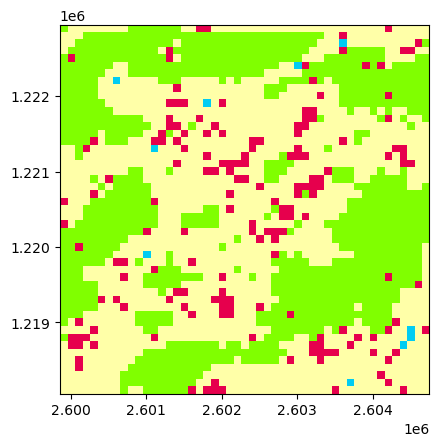

In [ ]:
ldf.clip_by_geometry(landscape_geoms.iloc[0]).plot(
    "AS18_4", cmap=sls.noas04_4_cmap, norm=sls.noas04_4_norm
)

The last preprocessing step is to actually initialize a pylandstats `Landscape` instance for each of the landscape so that we can then compute the metrics:

In [ ]:
landscapes = []

with tempfile.TemporaryDirectory() as tmp_dir:
    tmp_filepath = path.join(tmp_dir, "foo.tif")
    # TODO: use convex hull of all landscape_geoms?
    ldf.to_geotiff(tmp_filepath, lulc_col)
    with rio.open(tmp_filepath) as src:
        for landscape_geom in tqdm.tqdm(landscape_geoms):
            img, transform = mask.mask(
                src, [landscape_geom], all_touched=True, nodata=0, crop=True
            )
            landscapes.append(pls.Landscape(img[0], res=ldf.res, transform=transform))

/home/martibosch/mambaforge/envs/pylandstats/lib/python3.11/site-packages/swisslandstats/dataframe.py:138: RuntimeWarning: invalid value encountered in cast
  arr[-i, j] = self[column].values
100%|███████████████████████████████████████████████| 24/24 [00:00<00:00, 976.41it/s]


<a id='cluster-analysis-ten-metrics-pca'></a> 
## Cluster analysis with ten metrics and principal component analysis (PCA)

For each landscape, we now compute a set of ten landscape metrics chosen loosely following the work of Nowosad and Stepinski [3] (the list of metrics is actually adapted considering the metrics that are currently implemented in pylandstats). Then, landscapes will be classified based on the computed metrics into a pre-defined number of clusters. In order to better visualize the results, a principal component analysis (PCA) will serve to reduce the dimensionality (i.e., number of metrics). 

We will use the `ClusterAnalysis` class defined above as follows:

In [ ]:
ten_metrics = [
    # area and edge
    "area_mn",
    "perimeter_mn",
    "patch_density",
    "edge_density",
    # shape
    "fractal_dimension_am",
    "shape_index_mn",
    # aggregation
    "contagion",
    "effective_mesh_size",
    "landscape_shape_index",
    # diversity
    "shannon_diversity_index",
]
ten_ca = ClusterAnalysis(
    landscapes,
    ten_metrics,
    kmeans_kws=kmeans_kws,
    pca_kws=pca_kws,
    silhouette_score_kws=silhouette_score_kws,
)

100%|████████████████████████████████████████████████| 24/24 [00:02<00:00, 10.26it/s]
/home/martibosch/mambaforge/envs/pylandstats/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


We will now visualize the results of the cluster analysis as a scatter plot using the first and second PCA components:

[0.73295852 0.26658943]


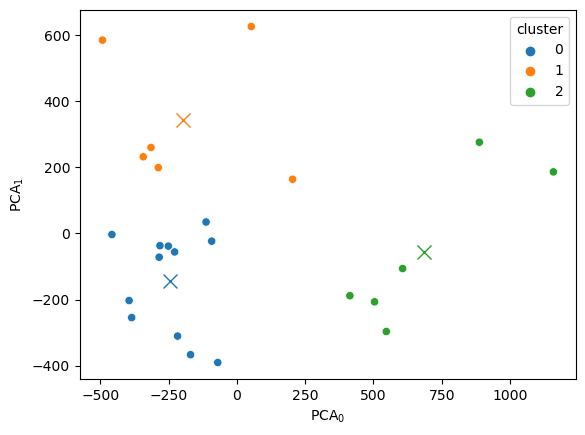

In [ ]:
print(ten_ca.pca.explained_variance_ratio_)
pca_ax = ten_ca.scatterplot_cluster_pca(center_plot_kws=center_plot_kws)

The first and second components account for about 73.30% and 0.27% of the variance respectively, hence together they represent a 99.95% of the total variance. We can also see the contribution of each metric to each component:

In [ ]:
pd.DataFrame(ten_ca.pca.components_, columns=ten_ca.metrics_df.columns)

,area_mn,perimeter_mn,patch_density,edge_density,fractal_dimension_am,shape_index_mn,contagion,effective_mesh_size,landscape_shape_index,shannon_diversity_index
0,0.013493,0.971881,-0.002014,-0.006375,0.000013,0.000101,0.008316,0.234841,-0.000816,-0.000144
1,0.019572,-0.235269,-0.002448,-0.034255,-0.000047,-0.000080,0.016577,0.970975,-0.004393,-0.000130


We can see that the first component is almost perfectly coincident with the mean patch perimeter, whereas the second is very strongly related to the effective mesh size. We can also visualize the scatterplots based on the landscape metrics:

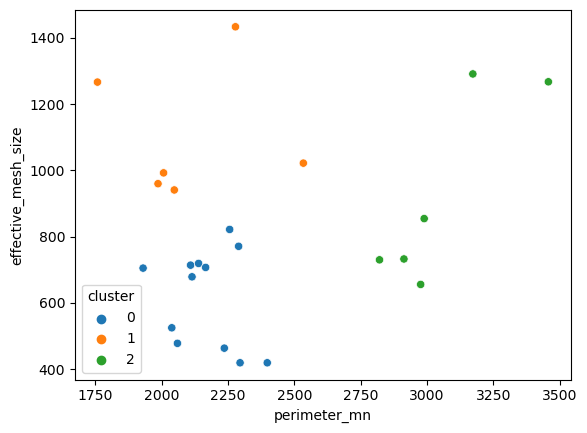

In [ ]:
area_edge_ax = ten_ca.scatterplot_cluster_metrics(
    metric_x="perimeter_mn", metric_y="effective_mesh_size"
)

In this analysis, it seems that clusters can easily be linearly-separated by means of the mean patch perimeter and effective mean size. Let us now see what the landscapes of each cluster look like:

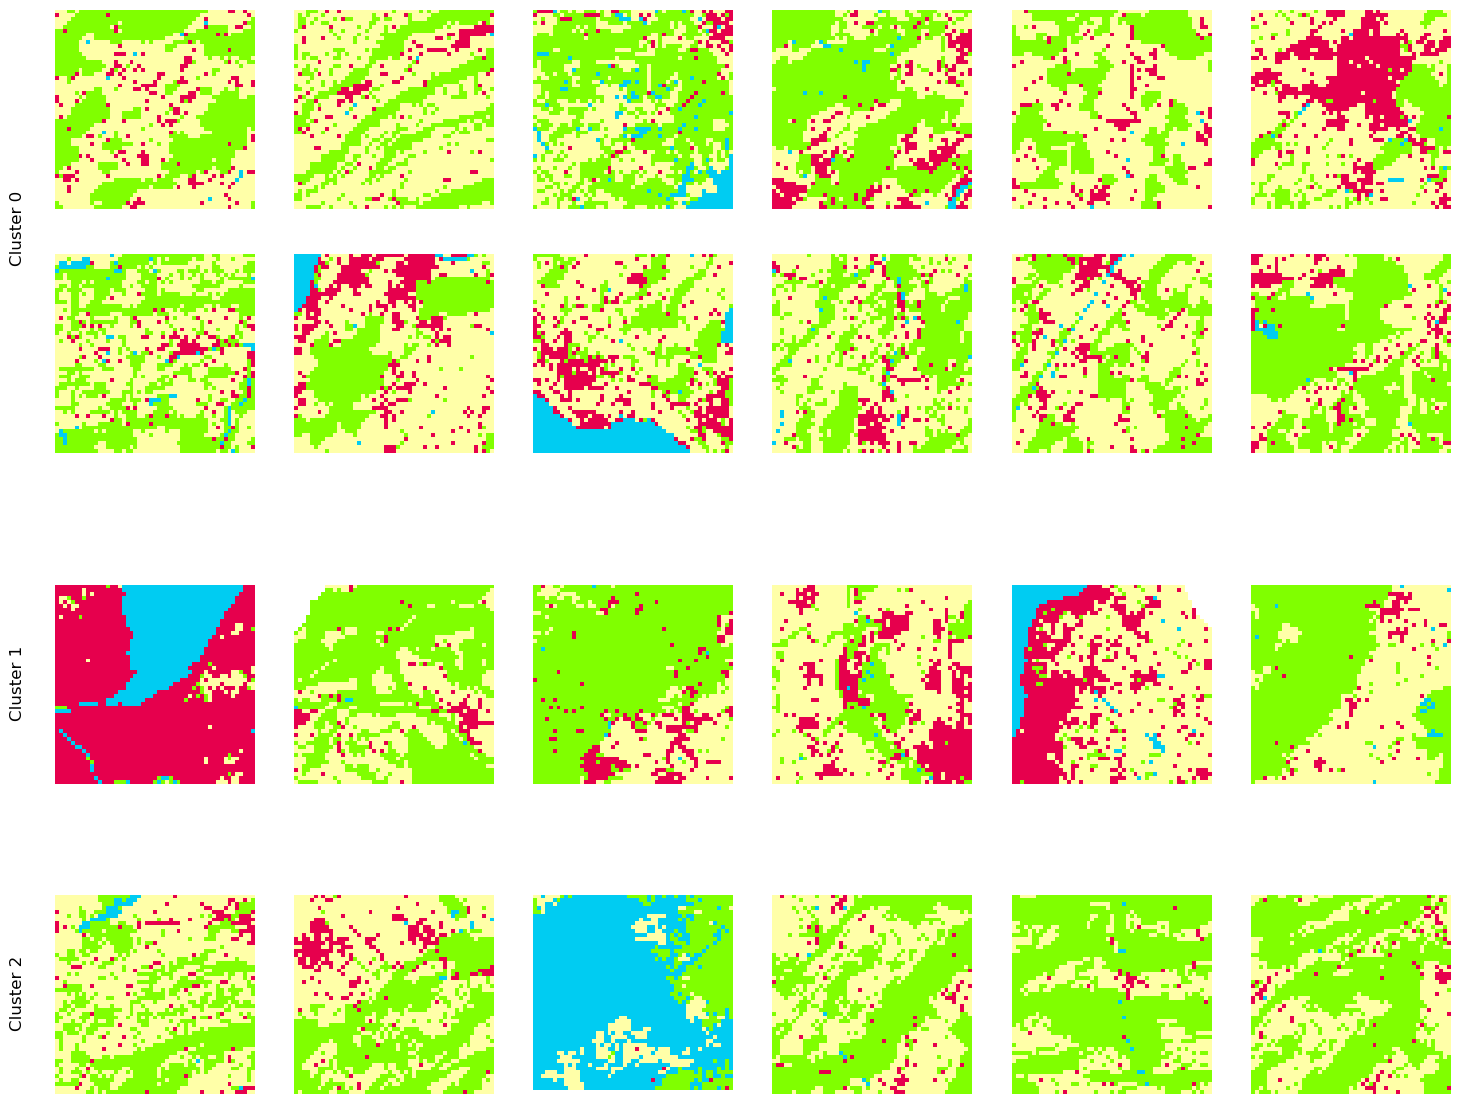

In [ ]:
ten_fig = ten_ca.plot_cluster_landscapes(num_cols, **plot_cluster_landscapes_kws)

In line with the scatter plot above, we can see that:

* *cluster 0* consists of landscapes with complex shapes and large amounts of edges between different classes
* *cluster 1* corresponds landscapes mostly dominated by large patches
* *cluster 2* consists of landscapes with a shape complexity that is somewhere in between the simplicity of *cluster 1* and the high shape complexity of *cluster 0*

## Information theory (IT)-based approach

Following the approach of Nowosad and Stepinski [1], we will now try to use an information theory (IT)-based approach to classify landscapes, i.e., the HYU diagram, where H and U respectively refer to [the Shannon's entropy](https://pylandstats.readthedocs.io/en/latest/landscape.html#pylandstats.Landscape.entropy) and [the relative mutual information criterion](https://pylandstats.readthedocs.io/en/latest/landscape.html#pylandstats.Landscape.relative_mutual_information) (see Nowosad and Stepinski [1] for more details). 

To perform this IT-based analsyis, can use the `ClusterAnalysis` class again, but since we are only using two landscape metrics, there is not need for a PCA decomposition:

In [ ]:
it_metrics = ["entropy", "relative_mutual_information"]
it_ca = ClusterAnalysis(
    landscapes,
    it_metrics,
    kmeans_kws=kmeans_kws,
    pca=False,
    silhouette_score_kws=silhouette_score_kws,
)

100%|███████████████████████████████████████████████| 24/24 [00:00<00:00, 126.43it/s]
/home/martibosch/mambaforge/envs/pylandstats/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


We can visualize the clusters in a two-dimensional scatter plot with each metric representing an axis:

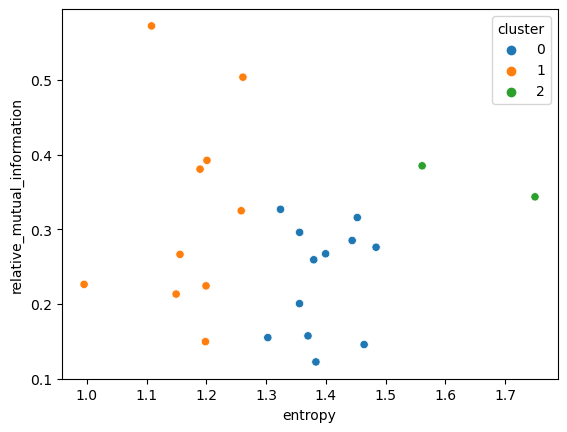

In [ ]:
it_ax = it_ca.scatterplot_cluster_metrics(
    metric_x="entropy", metric_y="relative_mutual_information"
)

Similarly, it seems that the clusters can be linearly-delineated based on two metrics.

Let us now visualize the landscapes of each cluster:

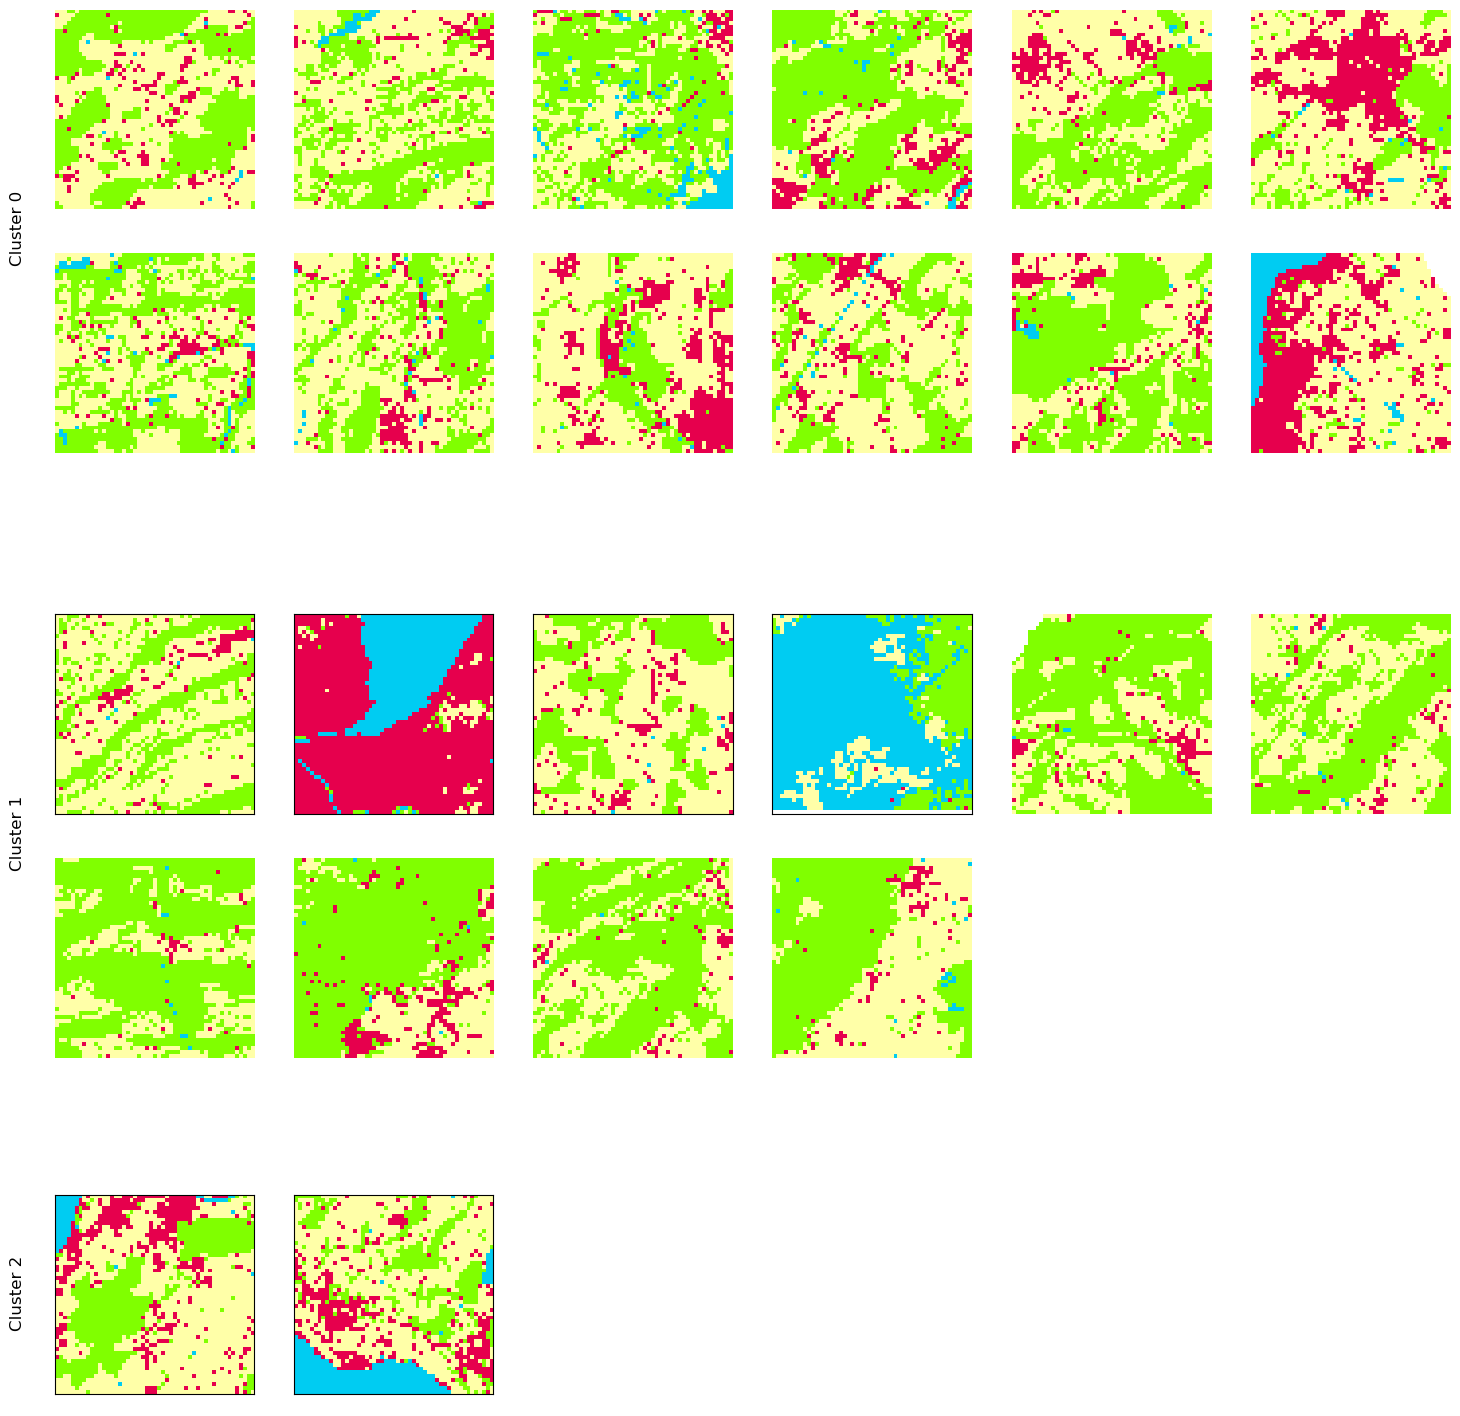

In [ ]:
it_fig = it_ca.plot_cluster_landscapes(num_cols, **plot_cluster_landscapes_kws)

We can see that the *cluster 0* seems to group the landscapes with the most complex shapes (hence the highest entropy values), but in this IT-based the landscapes of *cluster 2* appear more similar to those of *cluster 0*. To conclude, we can evaluate the consistency of the ten metrics-based and the IT-based cluster classifications by comparing their respective [silhouette scores](https://en.wikipedia.org/wiki/Silhouette_(clustering)):

In [ ]:
print("Silhouette scores:")
print(f"Ten metrics: {ten_ca.silhouette_score}")
print(f"IT: {it_ca.silhouette_score}")

Silhouette scores:
Ten metrics: 0.45647303076123796
IT: 0.39316967542603004


As we can see, the ten metrics-based cluster classification in this notebook is more consistent (higher silhouette score) than the IT-based approach.

Note however that the purpose of this notebook is to show how pylandstats can be used to cluster landscapes. The parameters of the analysis have been chosen for pedagogical purposes hence the results are not intended to be interpreted in landscape ecology/information theory terms.

## References

1. Nowosad, J., & Stepinski, T. F. (2019). Information theory as a consistent framework for quantification and classification of landscape patterns. Landscape Ecology, 34(9), 2091-2101.
2. Bosch, M. (2019). swisslandstats-geopy: Python tools for the land statistics datasets from the Swiss Federal Statistical Office. Journal of Open Source Software, 4(41), 1511.
3. Nowosad, J., & Stepinski, T. F. (2018). Global inventory of landscape patterns and latent variables of landscape spatial configuration. Ecological Indicators, 89, 159-167.